## Paso a Lab

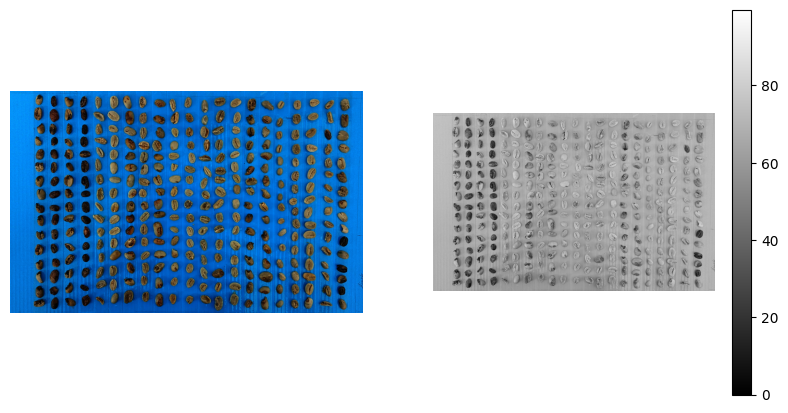

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

RGB_LAB_MATRIX_D65 = np.array([[0.4124, 0.3576, 0.1805],
                               [0.2126, 0.7152, 0.0722],
                               [0.0193, 0.1192, 0.9505]])

XYZ_D65_STANDAR_ILUMINATION = np.array([0.950456, 1.0, 1.088754])
EPSILON = 216 / 24389


def read_image(path):
    image = cv.imread(path)[...,::-1]/255
    return image

def RGB2Lab(image):
    lab_image = cv.cvtColor(image, cv.COLOR_RGB2Lab)
    return lab_image

def unfolding(img:np.ndarray):
    rows, columns, bands = img.shape
    img_unfold = np.reshape(img,(rows*columns,bands))
    return img_unfold

def folding(img:np.ndarray, rows, columns, bands):
    img_fold = np.reshape(img,(rows,columns,bands))
    return img_fold

def _companding_sRGB(rgb_values: np.ndarray):

    idx = rgb_values <= 0.04045
    rgb_values[idx] =  rgb_values[idx]/(12.92)
    rgb_values[~idx] = ((rgb_values[~idx]+0.055)/1.055)**2.4
    return rgb_values

def _RGB2Lab(array_RGB: np.ndarray,fold: bool = True):

    if array_RGB.ndim == 3:
        rows, columns, bands = array_RGB.shape
        array_RGB = unfolding(array_RGB)
    array_RGB = _companding_sRGB(array_RGB)
    xyz_linear = np.dot(array_RGB, RGB_LAB_MATRIX_D65.T)
    xyz_normalized = xyz_linear / XYZ_D65_STANDAR_ILUMINATION
    linear_condition = xyz_normalized > EPSILON
    XYZ = np.where(linear_condition, xyz_normalized ** (1 / 3), (xyz_normalized * 903.3 + 16) / 116)
    L = 116 * XYZ[:, 1] - 16
    L = np.clip(L, 0, 100)
    a = 500 * (XYZ[:, 0] - XYZ[:, 1])
    b = 200 * (XYZ[:, 1] - XYZ[:, 2])
    Lab = np.column_stack((L, a, b))
    if fold is True:
        Lab = folding(Lab, rows, columns, bands)
    return Lab


image_path = '/content/drive/MyDrive/cafe_ind/cafe_guia_enfermos_1.jpg'
#image_path = '/content/drive/MyDrive/cafe_ind/cafe_guia_sanos_1.jpg'
image = read_image(image_path)
lab_image = _RGB2Lab(image)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(lab_image[...,0], cmap='gray') # Lab ---> 0,1,2

plt.colorbar()
plt.axis('off')

plt.show()

## Mascara binaria


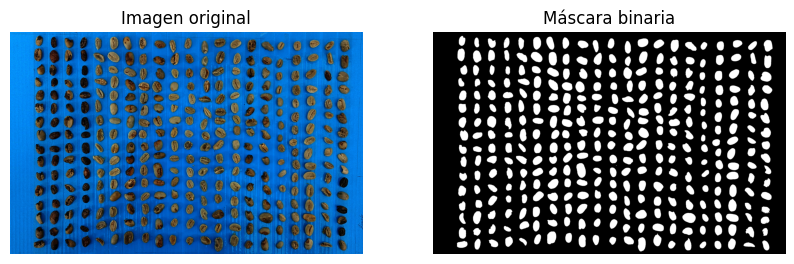

In [2]:
threshold = 0  # Umbral para la máscara
binary_mask = lab_image[..., 2] > threshold

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title("Imagen original")

plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.title("Máscara binaria")

plt.show()

##Detección de bordes y cierre morfológico

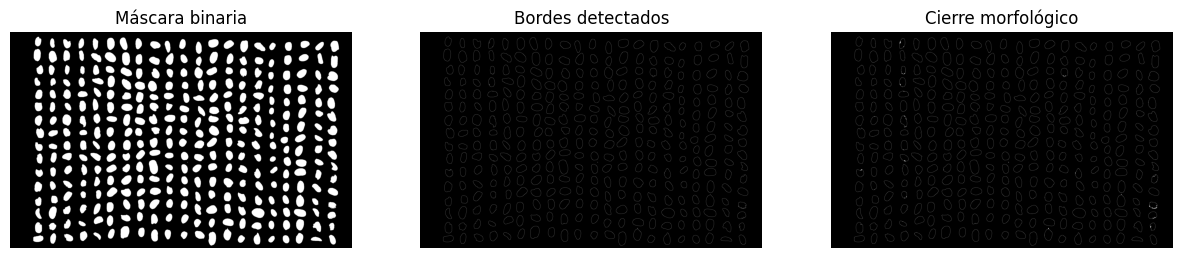

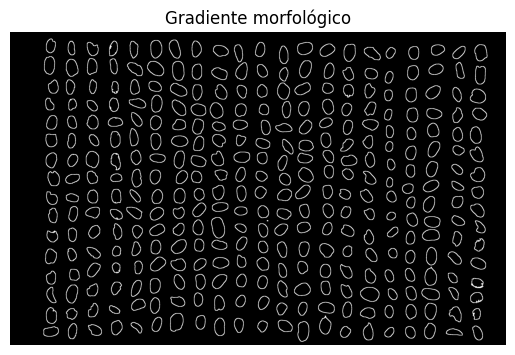

In [3]:

# Detección de bordes usando Canny
edges = cv.Canny((binary_mask * 255).astype(np.uint8), 50, 150)

# Operación de cierre morfológico
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))  # Kernel rectangular de 5x5
closed_mask = cv.morphologyEx(edges, cv.MORPH_CLOSE, kernel)

# Visualización de los resultados
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.title("Máscara binaria")

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.title("Bordes detectados")

plt.subplot(1, 3, 3)
plt.imshow(closed_mask, cmap='gray')
plt.axis('off')
plt.title("Cierre morfológico")

plt.show()

gradient = cv.morphologyEx((binary_mask * 255).astype(np.uint8), cv.MORPH_GRADIENT, kernel)

# Visualizar el gradiente morfológico
plt.imshow(gradient, cmap='gray')
plt.axis('off')
plt.title("Gradiente morfológico")
plt.show()

##Conteo de granos

Número de objetos cerrados detectados: 339


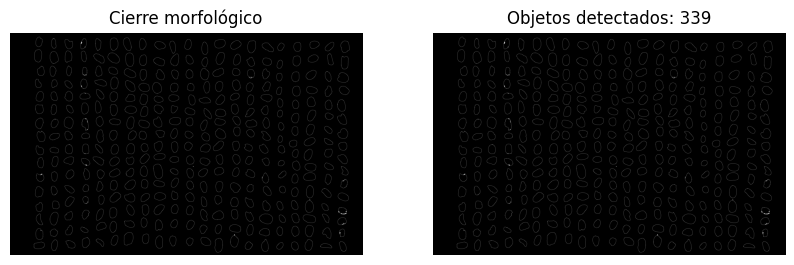

In [4]:
# Contar los objetos cerrados
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(closed_mask, connectivity=8)

# Mostrar la cantidad de objetos detectados
print(f"Número de objetos cerrados detectados: {num_labels - 1}")  # Resta 1 para ignorar el fondo

# Visualización de los objetos detectados
output_image = np.ones_like(closed_mask, dtype=np.uint8)
for i in range(1, num_labels):  # Ignorar el fondo (etiqueta 0)
    output_image[labels == i] = 255

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(closed_mask, cmap='gray')
plt.axis('off')
plt.title("Cierre morfológico")

plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.title(f"Objetos detectados: {num_labels - 1}")

plt.show()

##Eliminar fondo


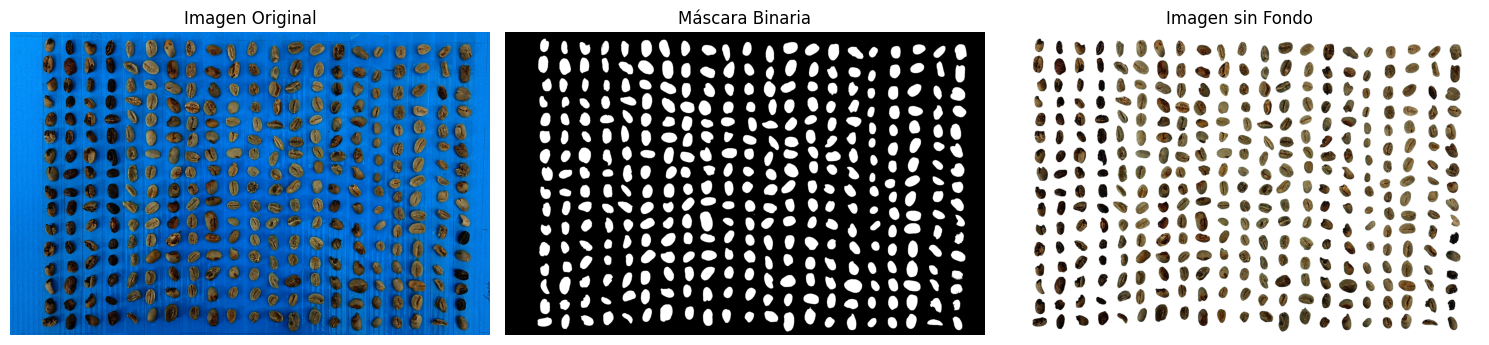

In [5]:

threshold = 0  # Umbral para la máscara
binary_mask = lab_image[..., 2] > threshold

# Crear una imagen sin fondo
image_no_background = np.ones_like(image)  # Crear una imagen en negro
image_no_background[binary_mask] = image[binary_mask]  # Copiar solo los objetos detectados

# Visualización
plt.figure(figsize=(15, 5))

# Imagen original
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis('off')
plt.title("Imagen Original")

# Máscara binaria
plt.subplot(1, 3, 2)
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')
plt.title("Máscara Binaria")

# Imagen sin fondo
plt.subplot(1, 3, 3)
plt.imshow(image_no_background)
plt.axis('off')
plt.title("Imagen sin Fondo")

plt.tight_layout()
plt.show()

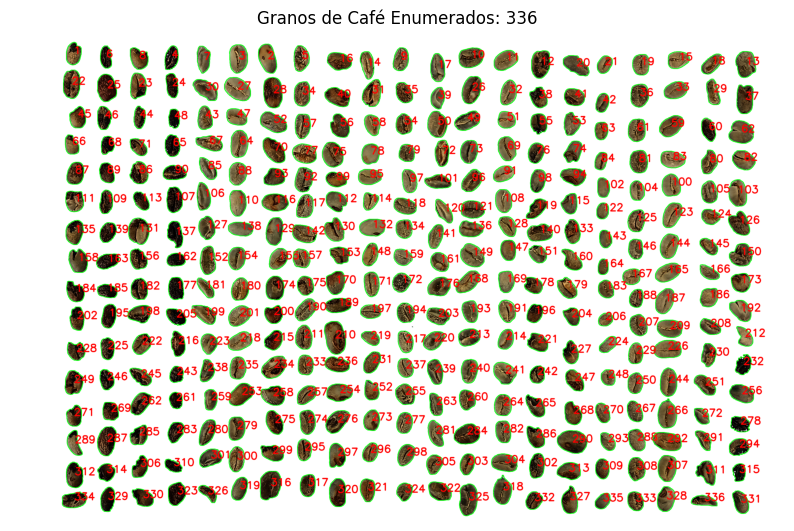

In [6]:

# Detección de bordes usando Canny
edges = cv.Canny((binary_mask * 255).astype(np.uint8), 50, 150)

# Operación de cierre morfológico
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))  # Kernel rectangular de 5x5

# Crear una copia de la imagen original para superponer los contornos y la numeración
labeled_image = (image_no_background * 255).astype(np.uint8).copy()

gradient = cv.morphologyEx((binary_mask * 255).astype(np.uint8), cv.MORPH_GRADIENT, kernel)

# Encontrar los contornos en la imagen del cierre morfológico
contours, _ = cv.findContours(gradient , cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Ordenar los contornos de izquierda a derecha y de arriba hacia abajo
sorted_contours = sorted(contours, key=lambda c: cv.boundingRect(c)[1] * labeled_image.shape[1] + cv.boundingRect(c)[0])

count = 0
for i, c in enumerate(sorted_contours):
    x, y, w, h = cv.boundingRect(c)
    if w > 10 and h > 10:  # Filtrar contornos pequeños para evitar falsos positivos
        count += 1
        # Dibujar contorno del grano
        cv.drawContours(labeled_image, [c], -1, (0, 255, 0), 2)

        # Colocar el número del grano en el centro del contorno
        center_x, center_y = x + w // 2, y + h // 2
        cv.putText(labeled_image, str(count), (center_x, center_y),
                   cv.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 3, cv.LINE_AA)

# Mostrar imagen con los granos enumerados
plt.figure(figsize=(10, 10))
plt.imshow(labeled_image)
plt.title(f'Granos de Café Enumerados: {count}')
plt.axis('off')
plt.show()

##Croma

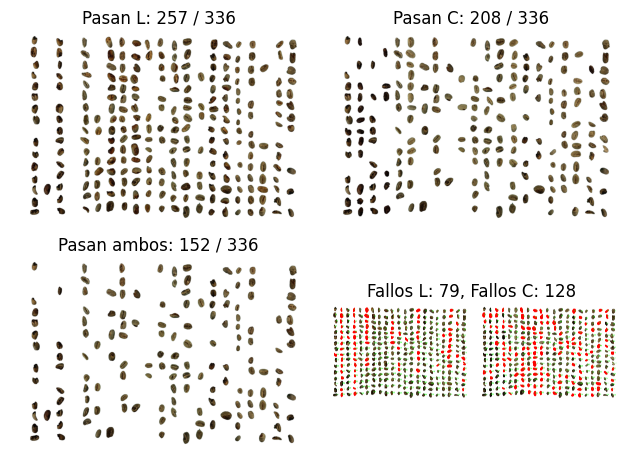

In [19]:
# Parámetros de filtrado
l_min, l_max = 38, 68
c_min, c_max = 10, 20

# Extraer canal L del espacio Lab

L_channel = lab_image[..., 0]

# Etiquetado de componentes (fondo = 0, objetos = 1..N)
num_labels, labels = cv.connectedComponents(closed_mask)

# Preparar imágenes base (tonalidad de fondo blanca)
labeled_image = (image_no_background * 255).astype(np.uint8).copy()
image_pass_L    = np.ones_like(image)  # solo granos que pasan luminancia
image_pass_C    = np.ones_like(image)  # solo granos que pasan croma
image_pass_both = np.ones_like(image)  # solo granos que pasan ambos filtros
highlighted_L   = labeled_image.copy() # resaltado L fallidos
highlighted_C   = labeled_image.copy() # resaltado C fallidos

# Contadores e info
grain_info = []
failed_L = failed_C = failed_both = 0

# Encontrar y ordenar contornos para numeración
contours, _ = cv.findContours(closed_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
sorted_contours = sorted(contours,
    key=lambda c: cv.boundingRect(c)[1] * labeled_image.shape[1] + cv.boundingRect(c)[0])

for i, cnt in enumerate(sorted_contours):
    x, y, w, h = cv.boundingRect(cnt)
    if w < 10 or h < 10:
        continue

    # Etiqueta asociada al contorno
    label_id = i + 1
    coords = np.argwhere(labels == label_id)
    if coords.size == 0:
        continue

    # Calcular medias
    L_vals = L_channel[coords[:,0], coords[:,1]]
    mean_L = L_vals.mean()
    a_vals = lab_image[coords[:,0], coords[:,1], 1].astype(np.float32)
    b_vals = lab_image[coords[:,0], coords[:,1], 2].astype(np.float32)
    chroma_vals = np.sqrt(a_vals**2 + b_vals**2)
    mean_C = chroma_vals.mean()

    # Guardar info
    total_px = len(coords)
    pass_L = l_min <= mean_L <= l_max
    pass_C = c_min < mean_C < c_max
    grain_info.append((label_id, total_px, mean_L, mean_C, pass_L, pass_C))

    # Construir imágenes de paso
    if pass_L:
        image_pass_L[coords[:,0], coords[:,1]] = image[coords[:,0], coords[:,1]]
    else:
        failed_L += 1
        highlighted_L[coords[:,0], coords[:,1]] = [255,0,0]

    if pass_C:
        image_pass_C[coords[:,0], coords[:,1]] = image[coords[:,0], coords[:,1]]
    else:
        failed_C += 1
        highlighted_C[coords[:,0], coords[:,1]] = [255,0,0]

    if pass_L and pass_C:
        image_pass_both[coords[:,0], coords[:,1]] = image[coords[:,0], coords[:,1]]
    else:
        failed_both += 0  # opcional resalte si se desea

    # Dibujar número en la imagen resaltada
    cx, cy = x + w//2, y + h//2
    cv.putText(highlighted_L, str(label_id), (cx, cy),
               cv.FONT_HERSHEY_SIMPLEX, 1.2, (0,255,0), 2, cv.LINE_AA)
    cv.putText(highlighted_C, str(label_id), (cx, cy),
               cv.FONT_HERSHEY_SIMPLEX, 1.2, (0,255,0), 2, cv.LINE_AA)

# Guardar info en txt
with open("granos_filtro_combinado.txt", "w") as f:
    f.write("ID | Total_px | Mean_L | Mean_C | Pass_L | Pass_C\n")
    for info in grain_info:
        f.write(f"{info[0]:<3} | {info[1]:<8} | {info[2]:<6.2f} | {info[3]:<6.2f} | {info[4]} | {info[5]}\n")

# Mostrar resultados\ nplt.figure(figsize=(12,8))
# Separado: Luminancia
plt.subplot(2,2,1)
plt.imshow(image_pass_L)
plt.title(f"Pasan L: {sum(1 for g in grain_info if g[4])} / {len(grain_info)}")
plt.axis('off')

# Separado: Croma
plt.subplot(2,2,2)
plt.imshow(image_pass_C)
plt.title(f"Pasan C: {sum(1 for g in grain_info if g[5])} / {len(grain_info)}")
plt.axis('off')

# Combinado: ambos filtros
plt.subplot(2,2,3)
plt.imshow(image_pass_both)
plt.title(f"Pasan ambos: {sum(1 for g in grain_info if g[4] and g[5])} / {len(grain_info)}")
plt.axis('off')

# Resaltados de fallos L y C
plt.subplot(2,2,4)
plt.imshow(np.hstack([highlighted_L, highlighted_C]))
plt.title(f"Fallos L: {failed_L}, Fallos C: {failed_C}")
plt.axis('off')

plt.tight_layout()
plt.show()


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

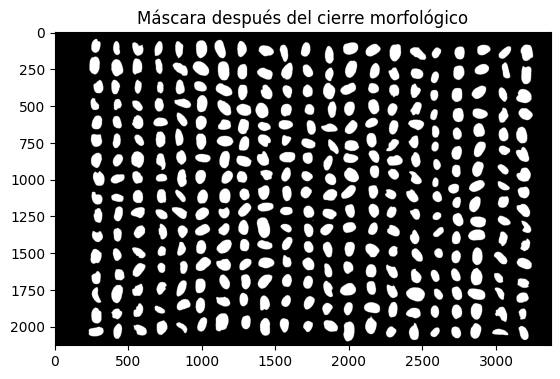

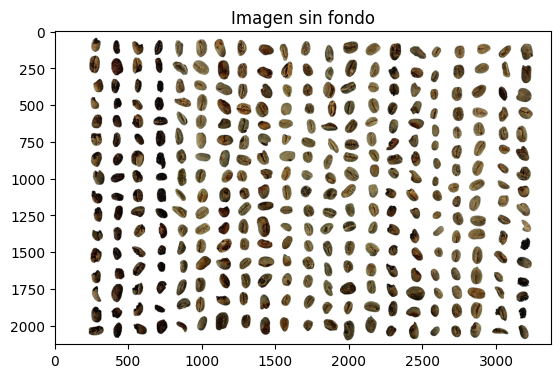

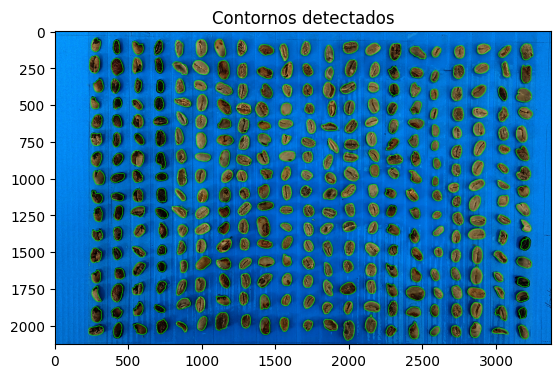

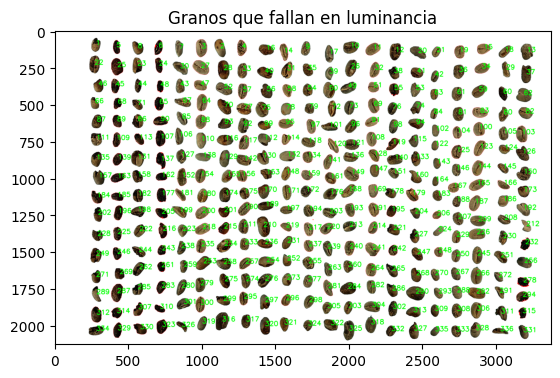

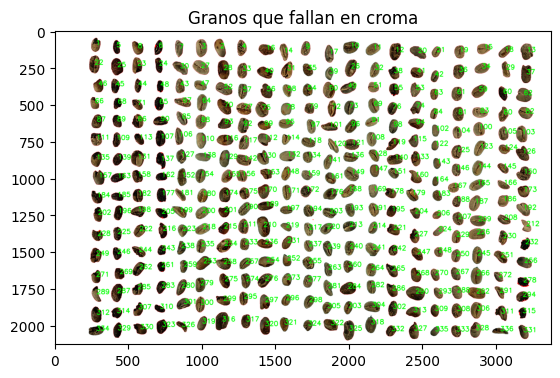

In [17]:
#rectificacion de info de lo granos

coords = np.argwhere(labels == count)
print(np.unique(labels))  # Debe mostrar valores mayores a 0 si los granos están etiquetados


plt.imshow(closed_mask, cmap='gray')
plt.title('Máscara después del cierre morfológico')
plt.show()
plt.imshow(image_no_background)
plt.title('Imagen sin fondo')
plt.show()
debug_image = image.copy()
cv.drawContours(debug_image, contours, -1, (0, 255, 0), 2)
plt.imshow(debug_image)
plt.title('Contornos detectados')
plt.show()

plt.imshow(highlighted_image_L)
plt.title('Granos que fallan en luminancia')
plt.show()

plt.imshow(highlighted_image_C)
plt.title('Granos que fallan en croma')
plt.show()

##Filtros uno a uno

In [11]:

# Definir umbrales para clasificación
CIRCULARITY_THRESHOLD = 0.74  # Umbral para circularidad
COMPACTNESS_THRESHOLD = 14.3   # Umbral para compacidad

##Geometrico y depues luminancia ESTE ES

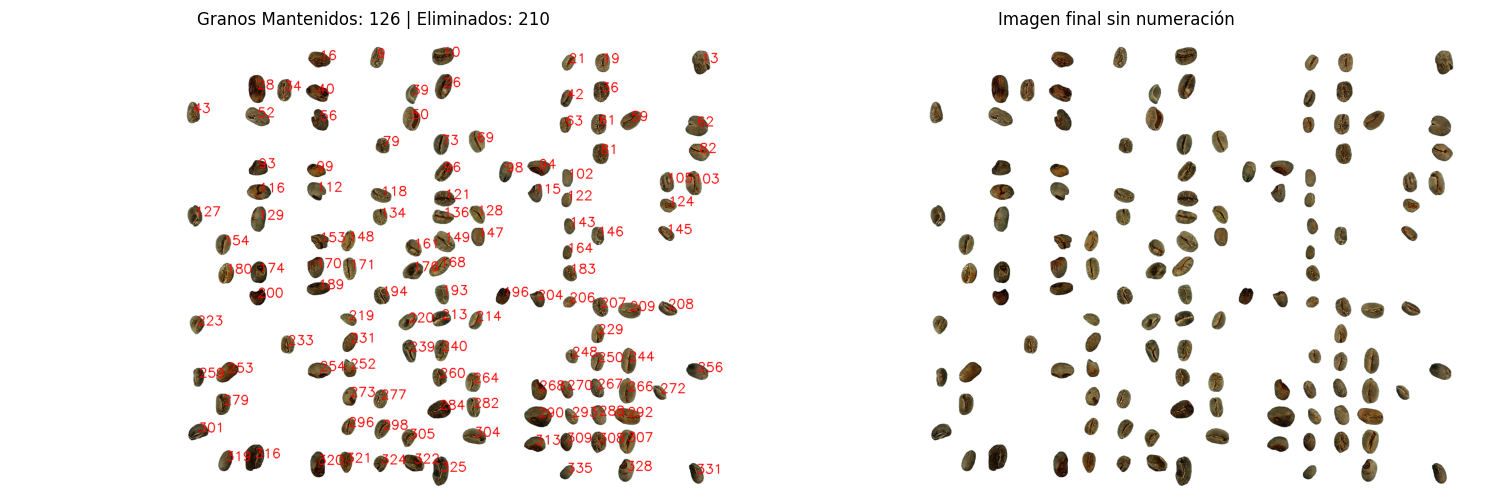

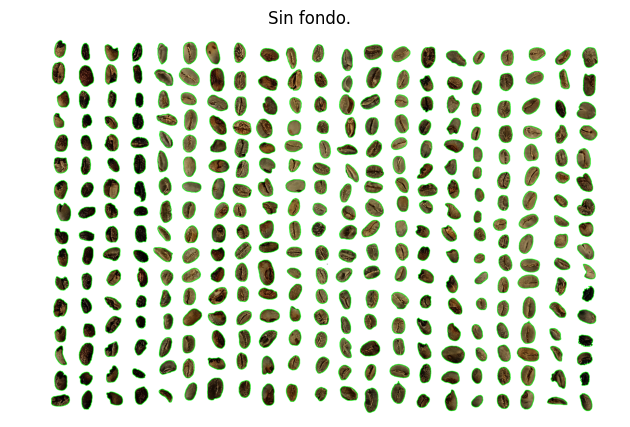


Resumen de eliminaciones:
Total eliminados: 210
  - Eliminados por Luminancia: 79
  - Eliminados por Circularidad: 52
  - Eliminados por Textura: 79
La información se ha guardado en '_filtros_textura.txt'.


In [12]:
# Parámetros de los filtros
L_min, L_max =  38, 68  # Rango de luminancia aceptado
circularidad_min =  0.76   # Circularidad mínima aceptada
#textura_min = 6.5  # Desviación estándar mínima de intensidad aceptada
textura_max = 14  # Desviación estándar máxima de intensidad aceptada

# Extraer el canal L (luminancia)
L_channel = lab_image[..., 0]

# Crear una máscara binaria inicial usando el canal b
threshold = 0
binary_mask = lab_image[..., 2] > threshold

# Aplicar cierre morfológico para eliminar ruido y unir regiones fragmentadas
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
closed_mask = cv.morphologyEx((binary_mask * 255).astype(np.uint8), cv.MORPH_CLOSE, kernel)

# Encontrar contornos en la máscara cerrada
contours, _ = cv.findContours(closed_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Filtrar contornos pequeños
min_size = 10
filtered_contours = [c for c in contours if cv.boundingRect(c)[2] > min_size and cv.boundingRect(c)[3] > min_size]

# Ordenar los contornos de izquierda a derecha y de arriba hacia abajo
sorted_contours = sorted(filtered_contours, key=lambda c: cv.boundingRect(c)[1] * closed_mask.shape[1] + cv.boundingRect(c)[0])

# Etiquetar los objetos filtrados
def label_from_contours(contours, shape):
    labeled_mask = np.zeros(shape[:2], dtype=np.int32)
    current_label = 1
    for contour in contours:
        cv.drawContours(labeled_mask, [contour], -1, current_label, thickness=cv.FILLED)
        current_label += 1
    return labeled_mask

labels = label_from_contours(sorted_contours, closed_mask.shape)

# Crear máscaras para granos mantenidos y eliminados en cada filtro
filtered_mask = np.zeros_like(binary_mask, dtype=bool)
eliminated_mask = np.zeros_like(binary_mask, dtype=bool)

# Contadores de granos
granos_mantener = 0
granos_eliminados = 0
eliminados_L = 0
eliminados_Circ = 0
eliminados_Text = 0

grano_info = []  # Guardar información de los granos en el orden correcto

# Aplicar los filtros en orden
for i, contour in enumerate(sorted_contours, start=1):
    coords = np.argwhere(labels == i)
    if len(coords) == 0:
        continue

    L_values = L_channel[coords[:, 0], coords[:, 1]]
    mean_L = np.mean(L_values)

    if not (L_min < mean_L < L_max):
        eliminated_mask[coords[:, 0], coords[:, 1]] = True
        grano_info.append((i, mean_L, "-", "-", "No pasa Luminancia"))
        eliminados_L += 1
        continue

    area = cv.contourArea(contour)
    perimeter = cv.arcLength(contour, True)

    if perimeter == 0:
        eliminated_mask[coords[:, 0], coords[:, 1]] = True
        grano_info.append((i, mean_L, "-", "-", "No pasa Circularidad"))
        eliminados_Circ += 1
        continue

    circularidad = (4 * np.pi * area) / (perimeter ** 2)

    if circularidad < circularidad_min:
        eliminated_mask[coords[:, 0], coords[:, 1]] = True
        grano_info.append((i, mean_L, circularidad, "-", "No pasa Circularidad"))
        eliminados_Circ += 1
        continue

    # Cálculo de la textura (desviación estándar de la intensidad)
    intensity_values = L_channel[coords[:, 0], coords[:, 1]]
    textura = np.std(intensity_values)  # Desviación estándar de la intensidad

    # Condición corregida: Eliminar granos fuera del rango de textura
    if  textura > textura_max:
        eliminated_mask[coords[:, 0], coords[:, 1]] = True
        grano_info.append((i, mean_L, circularidad, textura, "No pasa Textura"))
        eliminados_Text += 1
        continue

    filtered_mask[coords[:, 0], coords[:, 1]] = True
    granos_mantener += 1
    grano_info.append((i, mean_L, circularidad, textura, "Pasa"))

# Total de eliminados
granos_eliminados = eliminados_L + eliminados_Circ + eliminados_Text

# Crear imagen con fondo blanco y solo los granos mantenidos
image_with_kept_grains = np.ones_like(image) * 255
image_with_kept_grains[filtered_mask] = image[filtered_mask]

# Crear una copia sin numeración
image_without_numbers = image_with_kept_grains.copy()

# Dibujar números en los granos filtrados respetando el orden
for i, contour in enumerate(sorted_contours, start=1):
    if grano_info[i - 1][4] == "Pasa":  # Solo numerar los que pasaron
        x, y, w, h = cv.boundingRect(contour)
        cx, cy = x + w // 2, y + h // 2
        cv.putText(image_with_kept_grains, str(i), (cx, cy), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)

# Mostrar imágenes y gráficos
plt.figure(figsize=(15, 5))

# Imagen con números
plt.subplot(1, 2, 1)
plt.imshow(image_with_kept_grains)
plt.axis('off')
plt.title(f"Granos Mantenidos: {granos_mantener} | Eliminados: {granos_eliminados}")

# Imagen sin números
plt.subplot(1, 2, 2)
plt.imshow(image_without_numbers)
plt.axis('off')
plt.title("Imagen final sin numeración")

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plt.imshow(labeled_image)
plt.axis('off')
plt.title("Sin fondo.  ")
plt.show()

# Guardar la información en un archivo .txt respetando el orden
with open("_filtros_textura.txt", "w") as file:
    file.write(f"{'ID Grano':<10}{'Luminancia':<15}{'Circularidad':<15}{'Textura':<15}{'Resultado':<20}\n")
    file.write("-" * 70 + "\n")

    for i, mean_L, circularidad, textura, resultado in grano_info:
        L_text = f"{mean_L:.2f}" if isinstance(mean_L, float) else "-"
        C_text = f"{circularidad:.2f}" if isinstance(circularidad, float) else "-"
        T_text = f"{textura:.2f}" if isinstance(textura, float) else "-"
        file.write(f"{i:<10}{L_text:<15}{C_text:<15}{T_text:<15}{resultado:<20}\n")

    file.write("\nResumen:\n")
    file.write(f"Granos Mantenidos: {granos_mantener}\n")
    file.write(f"Granos Eliminados: {granos_eliminados}\n")
    file.write(f"Eliminados por Luminancia: {eliminados_L}\n")
    file.write(f"Eliminados por Circularidad: {eliminados_Circ}\n")
    file.write(f"Eliminados por Textura: {eliminados_Text}\n")

print("\nResumen de eliminaciones:")
print(f"Total eliminados: {granos_eliminados}")
print(f"  - Eliminados por Luminancia: {eliminados_L}")
print(f"  - Eliminados por Circularidad: {eliminados_Circ}")
print(f"  - Eliminados por Textura: {eliminados_Text}")
print("La información se ha guardado en '_filtros_textura.txt'.")

In [13]:
# Parámetros de los filtros
L_min, L_max = 0,100#38, 68  # Rango de luminancia aceptado
circularidad_min = 0 #0.76  # Circularidad mínima aceptada
textura_max = 99  # Desviación estándar máxima de intensidad aceptada
chroma_min, chroma_max = 0, 100  # Rango de croma aceptado


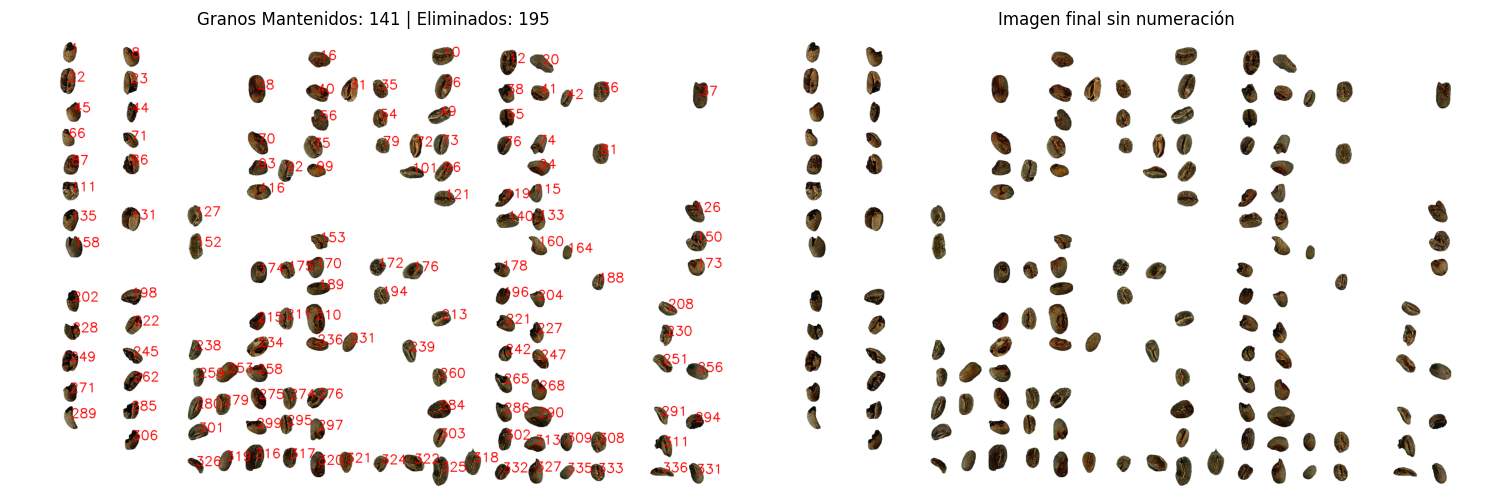


Resumen de eliminaciones:
Total eliminados: 195
  - Eliminados por Luminancia: 195
La información se ha guardado en '_filtro_L.txt'.


In [16]:
# Parámetros del filtro
L_min, L_max = 40, 60.5  # Rango de luminancia aceptado

# Extraer el canal L (luminancia)
L_channel = lab_image[..., 0]

# Crear una máscara binaria inicial usando el canal b
threshold = 0
binary_mask = lab_image[..., 2] > threshold

# Aplicar cierre morfológico para eliminar ruido y unir regiones fragmentadas
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
closed_mask = cv.morphologyEx((binary_mask * 255).astype(np.uint8), cv.MORPH_CLOSE, kernel)

# Encontrar contornos en la máscara cerrada
contours, _ = cv.findContours(closed_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Filtrar contornos pequeños
min_size = 10
filtered_contours = [c for c in contours if cv.boundingRect(c)[2] > min_size and cv.boundingRect(c)[3] > min_size]

# Ordenar los contornos de izquierda a derecha y de arriba hacia abajo
sorted_contours = sorted(filtered_contours, key=lambda c: cv.boundingRect(c)[1] * closed_mask.shape[1] + cv.boundingRect(c)[0])

# Etiquetar los objetos filtrados
def label_from_contours(contours, shape):
    labeled_mask = np.zeros(shape[:2], dtype=np.int32)
    current_label = 1
    for contour in contours:
        cv.drawContours(labeled_mask, [contour], -1, current_label, thickness=cv.FILLED)
        current_label += 1
    return labeled_mask

labels = label_from_contours(sorted_contours, closed_mask.shape)

# Crear máscaras para granos mantenidos y eliminados
filtered_mask = np.zeros_like(binary_mask, dtype=bool)
eliminated_mask = np.zeros_like(binary_mask, dtype=bool)

# Contadores de granos
granos_mantener = 0
granos_eliminados = 0
eliminados_L = 0

grano_info = []  # Guardar información de los granos en el orden correcto

# Aplicar filtro de luminancia
for i, contour in enumerate(sorted_contours, start=1):
    coords = np.argwhere(labels == i)
    if len(coords) == 0:
        continue

    L_values = L_channel[coords[:, 0], coords[:, 1]]
    mean_L = np.mean(L_values)

    if not (L_min <= mean_L <= L_max):
        eliminated_mask[coords[:, 0], coords[:, 1]] = True
        grano_info.append((i, mean_L, "No pasa Luminancia"))
        eliminados_L += 1
        continue

    filtered_mask[coords[:, 0], coords[:, 1]] = True
    granos_mantener += 1
    grano_info.append((i, mean_L, "Pasa"))

# Total de eliminados
granos_eliminados = eliminados_L

# Crear imagen con fondo blanco y solo los granos mantenidos
image_with_kept_grains = np.ones_like(image) * 255
image_with_kept_grains[filtered_mask] = image[filtered_mask]

# Crear una copia sin numeración
image_without_numbers = image_with_kept_grains.copy()

# Dibujar números en los granos filtrados respetando el orden
for i, contour in enumerate(sorted_contours, start=1):
    if grano_info[i - 1][2] == "Pasa":  # Solo numerar los que pasaron
        x, y, w, h = cv.boundingRect(contour)
        cx, cy = x + w // 2, y + h // 2
        cv.putText(image_with_kept_grains, str(i), (cx, cy), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)

# Mostrar imágenes y gráficos
plt.figure(figsize=(15, 5))

# Imagen con números
plt.subplot(1, 2, 1)
plt.imshow(image_with_kept_grains)
plt.axis('off')
plt.title(f"Granos Mantenidos: {granos_mantener} | Eliminados: {granos_eliminados}")

# Imagen sin números
plt.subplot(1, 2, 2)
plt.imshow(image_without_numbers)
plt.axis('off')
plt.title("Imagen final sin numeración")

plt.tight_layout()
plt.show()

# Guardar la información en un archivo .txt respetando el orden
with open("_filtro_L.txt", "w") as file:
    file.write(f"{'ID Grano':<10}{'Luminancia':<15}{'Resultado':<20}\n")
    file.write("-" * 45 + "\n")

    for i, mean_L, resultado in grano_info:
        L_text = f"{mean_L:.2f}" if isinstance(mean_L, float) else "-"
        file.write(f"{i:<10}{L_text:<15}{resultado:<20}\n")

    file.write("\nResumen:\n")
    file.write(f"Granos Mantenidos: {granos_mantener}\n")
    file.write(f"Granos Eliminados: {granos_eliminados}\n")
    file.write(f"Eliminados por Luminancia: {eliminados_L}\n")

print("\nResumen de eliminaciones:")
print(f"Total eliminados: {granos_eliminados}")
print(f"  - Eliminados por Luminancia: {eliminados_L}")
print("La información se ha guardado en '_filtro_L.txt'.")